<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/ATARI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPUの確認

In [ ]:
'''import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu) # new command'''

### GPUの確認

In [ ]:
!nvidia-smi

Tue Oct 27 13:09:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 準備
- [pfrl](https://github.com/pfnet/pfrl)　[(GitHub)](https://github.com/pfnet/pfrl)


In [1]:
!pip install pfrl > /dev/null
# Weights & Biases (optional)
%pip install -q wandb  
!wandb login  # 

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 133kB 18.1MB/s 
     |████████████████████████████████| 163kB 17.6MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 注意　
ENV_NAMEとしては、名前に **NoFrameskip** を含むものを選ぶこと

- [OpenAI Gym の Atari Environment の命名規則と罠について](https://qiita.com/keisuke-nakata/items/141fc53f419b102d942c)

In [3]:
import numpy as np
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow

# Atari ゲーム読み込みの確認

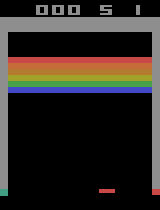

(210, 160, 3)


In [8]:
from pfrl.wrappers.atari_wrappers import make_atari,wrap_deepmind,FrameStack
ENV_NAME = 'BreakoutNoFrameskip-v0'
env=make_atari(ENV_NAME)
frame0 = env.reset()
cv2_imshow(frame0[:,:,::-1])
print(frame0.shape)

env=make_atari('BreakoutNoFrameskip-v0')　で (210,160,3) 形式の観測データが得られることがわかる。

なお、make_atari は4フレームおきに画像を取得する。

# Cropping

多くの例では、この縦長画面を 84x84 に単純にリサイズして使っているし、標準 wrapper も pfrl の wrapper も、baseline の wrapper もクロッピングするラッパーは見当たらないので、クロッピングはあまり効果がないのかもしれないのだが、効果のあるなしを比較するために、用意してみる。

In [5]:
from gym import ObservationWrapper
from gym.spaces import Box

class myCrop(ObservationWrapper):
    def __init__(self, env, tmgn=0, bmgn=0,lmgn=0,rmgn=0,igcolor=None,bgcolor=[0,0,0]):
        super(myCrop, self).__init__(env)
        self.tmgn, self.bmgn = tmgn, bmgn
        self.lmgn, self.rmgn = lmgn, rmgn
        self.igcolor,self.bgcolor = igcolor,bgcolor
        obs_shape = (210-tmgn-bmgn,160-lmgn-rmgn,3)
        self.observation_space = Box(low=0, high=255, shape=(210-tmgn-bmgn,160-lmgn-rmgn,3), dtype=np.uint8)
    def observation(self, observation):
      if self.igcolor != None:
        for  i in range(observation.shape[0]):
            for j in range(observation.shape[1]):
              for color in self.igcolor:
                observation[i,j]=self.bgcolor if (observation[i,j]==color).all() else observation[i,j] # 残基表示を消去
      RIGHT=observation.shape[1]-self.rmgn
      BOTTOM=observation.shape[0]-self.bmgn
      observation = observation[self.tmgn:BOTTOM,self.lmgn:RIGHT]
      return observation

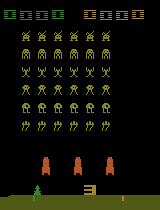

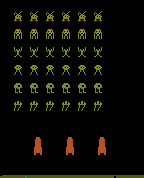

(210, 160, 3) (178, 144, 3)


In [6]:
# インベーダ専用の切り出しパラメータ
'''
Tmgn=20
Bmgn=12
Lmgn=8
Rmgn=8
NOCOLOR=[[162,134,56]]  # 背景と同一視するカラー

# PONGの切り出しパラメータ
Tmgn=34
BMmgn=16
Lmgn=0
Rmgn=0
NOCOLOR=None

# Boxing の切り出しパラメータ
Tmgn=32
Bmgn=30
Lmgn=28
Rmgn=28
NOCOLOR=None
'''
Tmgn=20
Bmgn=12
Lmgn=8
Rmgn=8
NOCOLOR=[[162,134,56]]  # 背景と同一視するカラー

ENV_NAME = 'SpaceInvadersNoFrameskip-v0'
#ENV_NAME = 'PongNoFrameskip-v0'
env=make_atari(ENV_NAME)
frame0=env.reset()
env=myCrop(env, tmgn=Tmgn, bmgn=Bmgn, lmgn=Lmgn, rmgn=Rmgn, igcolor=NOCOLOR)
frame1 = env.reset()
cv2_imshow(frame0[:,:,::-1])
cv2_imshow(frame1[:,:,::-1])
print(frame0.shape,frame1.shape)

↑　自機の数の数字が消えていることに注意

![Boxing](https://user-images.githubusercontent.com/5820803/102012464-f250d980-3d8d-11eb-94a9-2139b488e491.png)

![RiverraidNoFrameskip-v0](https://user-images.githubusercontent.com/5820803/102012500-29bf8600-3d8e-11eb-97e7-03db02ca5cf1.png)

# 8フレーム分をまとめたデータを作成する

(1, 84, 84)
(8, 84, 84)


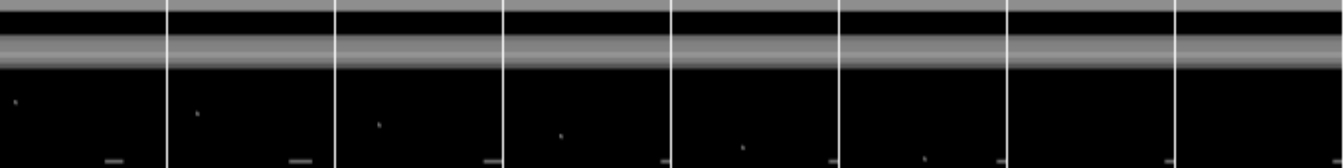

In [27]:
env=make_atari(ENV_NAME)
env=myCrop(env, tmgn=Tmgn, bmgn=Bmgn, lmgn=Lmgn, rmgn=Rmgn, igcolor=NOCOLOR)
env = wrap_deepmind(env,frame_stack=False,fire_reset=True)
print(env.observation_space.shape)
env = FrameStack(env,8,"chw")
print(env.observation_space.shape)
canvas = np.ones((84,8*85))*255
for i in range(8):
  canvas[:,85*i:85*i+84] = np.transpose(env.reset(),(0,1,2))[i]
cv2_imshow(cv2.resize(canvas,(16*84,2*84)))

env=wrap_deepmind(env,frame_stack=False,fire_reset=True) により、、
- グレイ変換
- 84x84 にリサイズ
を行い、  
env = FrameStack(env,8,"chw")により、  
- 8ステップ分（4フレームごとに取り出したフレームを8つ）をひとまとめにして、
8チャネル×84×84というサイズのでータを観測データとして出力


In [28]:
import pfrl
import torch
import torch.nn as nn
import gym
from pfrl import nn as pnn
from pfrl.initializers import init_chainer_default

# ここからが本編

In [29]:
Tmgn=10
Bmgn=50
Lmgn=8
Rmgn=8

ENV_NAME = 'RiverraidNoFrameskip-v0'
def mkenv():
  env=make_atari(ENV_NAME,max_frames = None)
  env=myCrop(env, tmgn=Tmgn, bmgn=Bmgn, lmgn=Lmgn, rmgn=Rmgn, igcolor=NOCOLOR)
  env.seed(np.random.seed())
  env = wrap_deepmind(env,episode_life=False,
            clip_rewards=False,
            scale = True,
            flicker=False,
            fire_reset=True,
            frame_stack=False,)
  env = FrameStack(env,8,"chw")
  return env

In [30]:
env = mkenv()
n_actions = 6 # env.action_space.n は18もあるが、左右とファイアしか使えない。

# DoubleDQN

## NN とオプティマイザーを２つずつ用意してみる

In [40]:
func_L = nn.Sequential(
    nn.Conv2d(8,64,8,4),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64,128,4,2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128,64,3,1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),    
    nn.Linear(7 * 7 * 64, 1024),
    nn.ReLU(),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.Linear(64, n_actions),
    pfrl.q_functions.DiscreteActionValueHead(),
)

# オプティマイザー
optimizer_A = torch.optim.Adam(func_L.parameters(), eps=1e-2)

optimizer_R = pfrl.optimizers.RMSpropEpsInsideSqrt(
        func_L.parameters(),
        lr=0.01,
        alpha=0.95,
        momentum=0.0,
        eps=1e-2,
        centered=True,
    )


# Epsilong Greedy も2通り用意
- ConstantEpsironGreedy
- LinearDecayEpsironGreedy

# Tensorboard の準備

In [32]:
# results フォルダのクリア
!rm -r ./results/*

rm: cannot remove './results/*': No such file or directory


In [33]:
from torch.utils.tensorboard import SummaryWriter
import wandb
wandb.tensorboard.patch(tensorboardX=True, pytorch=True)
wandb.init()
writer = SummaryWriter(log_dir="./results")

wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


# ハイパーパラメータ

In [41]:
gamma = 0.9
replay_buffer_size = 10 ** 3
if tf.test.gpu_device_name() == "":
  gpu = -1
else:
  gpu = 0
replay_buffer_size = 10 ** 3
# constantepsiron = 0.3 # .ConstantEpsilonGreedy用
final_epsilon = 0.1 # LinearDecayEpsilonGreedy用
final_exploration_frames = 5e4  # 50000 ε=0.1になるまでのステップ数

#explorerC = pfrl.explorers.ConstantEpsilonGreedy(
#    epsilon=constantepsiron, random_action_func=env.action_space.sample)
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=replay_buffer_size)

explorer = pfrl.explorers.LinearDecayEpsilonGreedy(
            start_epsilon = 0.5, 
            end_epsilon = final_epsilon,
            decay_steps = final_exploration_frames,
            random_action_func = lambda: np.random.randint(n_actions))

def phi(x):
    return np.asarray(np.array(x), dtype=np.float32) 

In [42]:
import datetime
print(datetime.datetime.now())

2020-12-13 13:54:35.712813


# 学習の実行
1エピソード当たりの最高ステップ数を1000として、100エピソード学習させてみる

まず、optimizer_Aとexplorer の組み合わせで試す

In [ ]:
print(datetime.datetime.now())

agent = pfrl.agents.DoubleDQN(
    func_L,
    optimizer_A,
    replay_buffer,
    gamma,
    explorer = explorer,
    replay_start_size=500,
    update_interval=5,
    target_update_interval=100,
    phi=phi,
    gpu=gpu,
)

n_episodes = 100
max_episode_len = 1000
totalsteps = 0
for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    print(i)
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        totalsteps += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        sdata = dict(agent.get_statistics())
        if  totalsteps % 100 == 0 :
          if not np.isnan(sdata['average_loss']) : writer.add_scalar('average_loss', sdata['average_loss'], totalsteps)
          if not np.isnan(sdata['average_q']) : writer.add_scalar('average_q', sdata['average_loss'], totalsteps)
          writer.add_scalar('R',R, totalsteps)
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    if i % 50 == 0:
        print('statistics:', agentALR.get_statistics())
print('Finished.')
writer.close()
agent.save('./drive/My Drive/M/modelTest')
print(datetime.datetime.now())

2020-12-13 13:54:47.508941
1
2


In [ ]:
#agentALR.save('./drive/My Drive/M/model003')
#print(datetime.datetime.now())

2020-10-27 15:50:29.791868


In [ ]:
# 読み出しは、
# agent.load('/content/drive/My Drive/M/agent')

# 評価モード



In [ ]:
with agentALR.eval_mode():
    for i in range(10):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agentALR.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == max_episode_len
            agentALR.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 22.0
evaluation episode: 1 R: 27.0
evaluation episode: 2 R: 26.0
evaluation episode: 3 R: 13.0
evaluation episode: 4 R: 25.0
evaluation episode: 5 R: 19.0
evaluation episode: 6 R: 27.0
evaluation episode: 7 R: 23.0
evaluation episode: 8 R: 10.0
evaluation episode: 9 R: 16.0
